# Forecasting LFPR with Gaussian Processes

This notebook describes an exercise using Gaussian Processes (GP) to predict the labor force participation rate by gender, age, and cohort. I use CPS data from 1976-1999 to fit the GP and then project out over the 2000-2016 period and compare to actual values. Overall, this is a promising first step as it exhibits more flexibility than existing methods, resulting in a good in-sample fit, and makes sensible out-of-sample predictions. In terms of next steps, two key issues are allowing for potential non-stationarity across ages (as is done in [this paper](http://ieeexplore.ieee.org.ezp-prod1.hul.harvard.edu/stamp/stamp.jsp?arnumber=6958906)) as well as expanding this to incorporate other covariates. 

## Methods

I start by treating the participation rate $y$ within a gender-age-cohort cell $X$ as a noisy observation of the true value, allowing for the true values to follow an arbitrary function $f$:
$$ y = f(X) + \epsilon$$
where the noise is normally distributed, $\epsilon \sim N(0,\sigma^2)$. I assume the function $f$ follows a Gaussian Process with covariance function $ k(X,X^{\\'}) $, i.e. $ f \sim GP(0,k(X,X^{\\'})) $. I use an anisotropic, squared-exponential covariance function:
$$k(X,X^{\\'})=\tau^2 \exp \left(-\sum^{p}_{j=1} \frac{(x_j - x_j^{\\'})^2}{2l^2_j}\right)$$
which allows for different length scales $l_j$ along different dimensions (i.e. gender, age, cohort). In total, this setup gives a very flexible functional form controlled by only five hyperparameters: the noise variance $\sigma^2$, the signal variance $\tau^2$, and the three length scales $l_j$. 

To estimate the model, I assign non-informative priors to the hyperparameters and then optimize to find their maximum a posteriori value, which is similar to an Empirical Bayes procedure. I use a log-uniform prior for $\sigma^2$, a square-root-uniform prior for $\tau^2$, and a uniform prior for each $l_j$. Optimization is conducted with the [GPstuff Matlab toolkit](http://research.cs.aalto.fi/pml/software/gpstuff/). 

Additionally, I estimate two other variants of this method:

1. Instead of assuming that the function $f(X)$ is drawn from a mean-zero Gaussian Process, I re-parameterize $f$ as $f(X)=m(X)+g(X)$, where $m$ is a mean function and $g$ is drawn from a mean-zero Gaussian Process. I estimate the mean function $m(X)$ as the average participation rate within each gender-age cell (i.e. averaging across cohorts). This mean function is subtracted from $y$ and then estimation proceeds as above. I add $m(X)$ back to the predicted values after estimation. This approach helps address problems due to the large movements in LFPR over the lifecycle (e.g. retirement). 

2. I apply an inverse logistic transformation to turn the bounded LFPR $y$ into an unbounded $\hat{y}$. Specifically, I define:
$$\hat{y}=\log \left( \frac{y}{1-y} \right)$$
where y is the LFPR expressed as a fraction. I then apply the above method (with the mean function estimated as in #1) to the transformed $\hat{y}$. This helps the model better capture changes in the LFPR during prime ages when participation is relatively close to its upper bound. 

## Plots 

The plots below show the actual LFPR by gender, age, and cohort along with the predicted values from each of the GP regressions. The plots are interactive and respond to the buttons, sliders, and boxes displayed below. For example, changing the list of cohorts to "1935,1945" will display only the data points for these two cohorts. As shown in the legend below the plots, cohorts are plotted in different colors and markers, while the predicted values from the GPs are differentiated by line pattern (e.g. solid, dashed, etc.). Adjusting the age range allows one to zoom in on particular ages. Additionally, data for the out-of-sample 2000-2016 period is shown in a lighter weight to differentiate it. Finally, checking the "Display age adjusted values?" checkbox subtracts the estimated mean function $m(X)$ from each of the data points. 

Box(children=(Label(value=u'List of Cohorts (separated by commas):'), Text(value=u'1930,1940,1950,1960,1970,', placeholder=u'1930,')))

IntRangeSlider(value=(16, 80), continuous_update=False, description=u'Age Range:', max=80, min=16)

IntRangeSlider(value=(1976, 2016), continuous_update=False, description=u'Year Range:', max=2016, min=1976)

Box(children=(Checkbox(value=True, description=u'Actual LFPR'), Checkbox(value=True, description=u'GP without mean function'), Checkbox(value=True, description=u'GP with age-specific mean'), Checkbox(value=True, description=u'GP with age-specific mean and logistic transform')))

Checkbox(value=False, description=u'Display age adjusted values?')

<IPython.core.display.Javascript object>


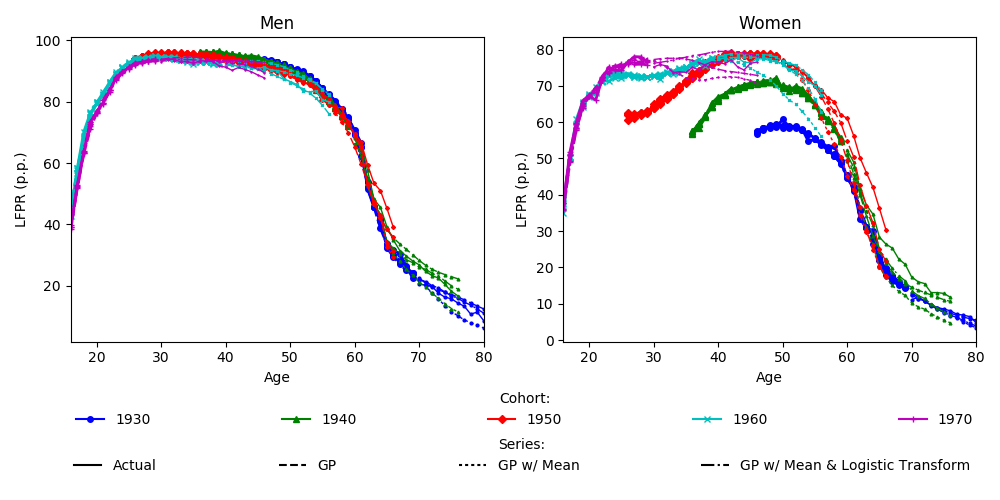

In [3]:
%matplotlib notebook
execfile("scripts/draw_plots.py")